# querying Aris from CasJobs : Count objects in low-level HTM cells
Useful links for plotting :
* https://coolum001.github.io/geopandasdisplay.html

In [12]:
import SciServer.CasJobs as cj
from datetime import datetime
import pandas
import geopandas as gpd
from shapely import wkt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [118]:
LSST="LSST_aris"
# code for perfect(unit?) sphere
SRID=104001

## count Object rows in HTM triangles at level LEVEL
Various different version of table used

In [133]:
%%time
#
# use temptable #a iso defining it inside CTE, as otherwise it will be executed multiple times in the union
#
def queryHTMCounts(object_table,level):
    pow=20-level
    sql="""
with a as (
select htmid/power(4,{pow}) as htmid_L, count(*) as num
  from m_object_cci
 group by  htmid/power(4,{pow}) 
)
select a.htmid_L,a.num, c.i, concat(c.ra,' ',c.dec) as pt 
into #pts
  from a cross apply htmid.GetCorners(a.htmid_L) c
;

with ptsExt as (  -- need to close the polygon
select * from #pts
union
select htmid_L,num,3,pt
  from #pts 
 where i=0
)
select htmid_L,max(num) as num, string_agg(i,'') as orientation
,      geography::STPolyFromText(concat('POLYGON((',STRING_AGG(pt,',') within group (order by i asc),'))'),104001) as triangle
from ptsExt
group by htmid_L
order by htmid_L

--drop table #pts 

    """.format(pow=20-level,object_table=object_table)
    return cj.executeQuery(sql,LSST)

CPU times: user 50 µs, sys: 4 µs, total: 54 µs
Wall time: 45.8 µs


In [136]:
%time htm5_cci=queryHTMCounts('m_object_cci',5)
%time htm5_cli=queryHTMCounts('m_object_cli',5)
%time htm5_page=queryHTMCounts('m_object_page',5)

CPU times: user 73 ms, sys: 17 ms, total: 90 ms
Wall time: 9.73 s
CPU times: user 98.4 ms, sys: 17.2 ms, total: 116 ms
Wall time: 10.1 s
CPU times: user 75.6 ms, sys: 15 ms, total: 90.6 ms
Wall time: 10.1 s


In [137]:
%time htm5_dp_htmid=queryHTMCounts('objectdp_htmid',5)

CPU times: user 85.7 ms, sys: 9.18 ms, total: 94.9 ms
Wall time: 10.1 s


# Plotting

In [125]:
def plotPRColored(_gdf, column=None,crs=None,figsize=[12,9],plot_title="", colorbar_title=None,colormap='copper_r'):
    """
    plot geopandas geo-dataframe colored by one of its columns.
    From https://stackoverflow.com/questions/54236083/geopandas-reduce-legend-size-and-remove-white-space-below-map find out 
    how to ensure the colorbar legend is same height as the plot
    """
    import matplotlib.pyplot as plt
    
    if crs is not None:
        gdf=_gdf.to_crs({"init":"epsg:{crs}".format(crs=crs)})
        plot_title=plot_title+" ({crs})".format(crs=crs)
    else:
        gdf=_gdf
        
    if column is None:
        ax = gdf.plot(figsize=figsize)
    
    else:
        if colorbar_title is None:
            colorbar_title=column
        ax = gdf.plot(column=column, cmap=colormap, \
                        figsize=figsize,vmin=min(gdf[column]), vmax=max(gdf[column]))
        #ax.grid() 
        # colorbar will be created by ...
        fig = ax.get_figure()
        # add colorbar axes to the figure
        # here, need trial-and-error to get [l,b,w,h] right
        # l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
        cbax = fig.add_axes([0.95, 0.3, 0.03, 0.39])   
        cbax.set_title(colorbar_title)

        sm = plt.cm.ScalarMappable(cmap=colormap, \
                        norm=plt.Normalize(vmin=min(gdf[column]), vmax=max(gdf[column])))
        # at this stage, 
        # 'cbax' is just a blank axes, with un needed labels on x and y axes

        # blank-out the array of the scalar mappable 'sm'
        sm._A = []
        # draw colorbar into 'cbax'
        fig.colorbar(sm, cax=cbax, format="%d")

    # dont use: plt.tight_layout()
    ax.set_title(plot_title)
    return ax

In [148]:
ghtm5=gpd.GeoDataFrame(htm5_cci,geometry=htm5_cci['triangle'].apply(wkt.loads))
# to transform to other coordinate ystems, must start with one that geopandas knows:
ghtm5.crs={'init' :'epsg:4326'}

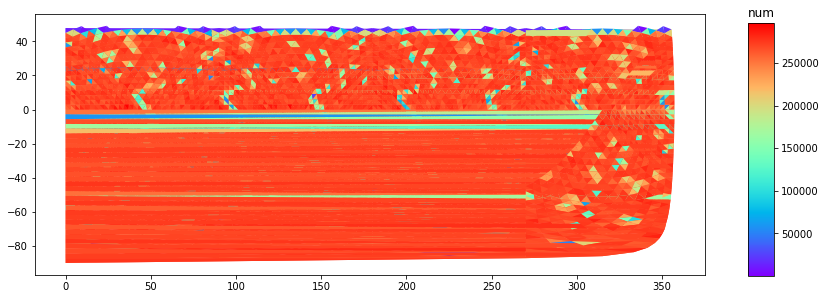

In [139]:
ax=plotPRColored(ghtm5,column='num',colormap='rainbow')

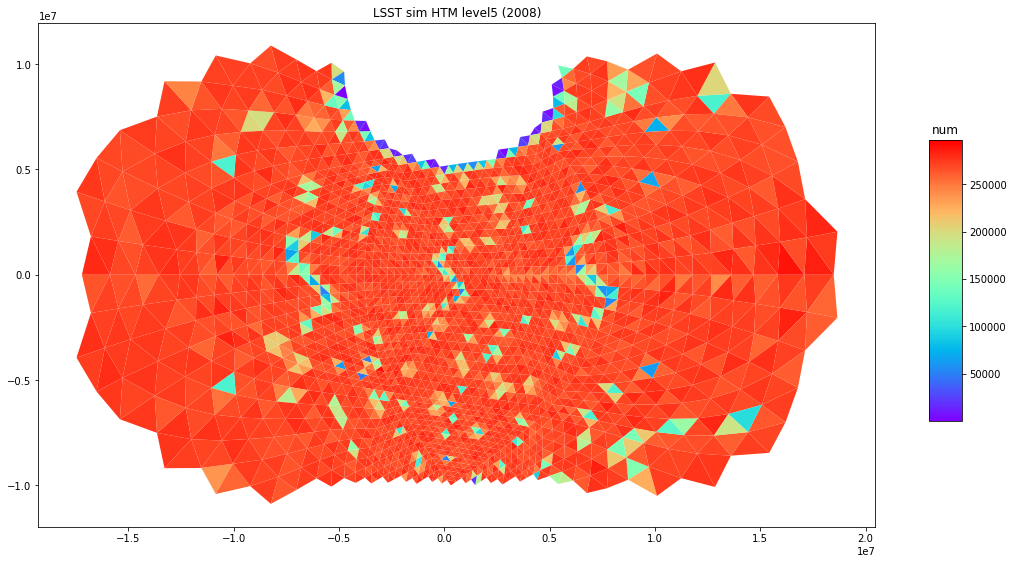

In [149]:
# plot df in different rojection (2008)
ax=plotPRColored(ghtm5,column='num',figsize=(15,10),plot_title="LSST sim HTM level5",crs=2008,colormap='rainbow')

# plot using Mollweide projection
geopandas does not support grid lines for this projection, also units seem to be meters rather than degrees.


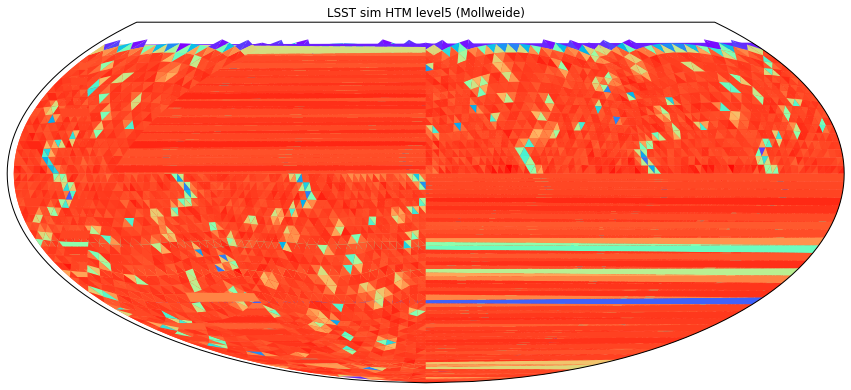

In [150]:
proj = ccrs.Mollweide()
name=str(proj).split(".")[2].split(" ")[0]
ghtm5_proj = ghtm5.to_crs(proj.proj4_init)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection=proj,title="LSST sim HTM level5 ({proj})".format(proj=name))
ghtm5_proj.plot(ax=ax,column='num', cmap='rainbow');